In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()

date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
#geosource = GeoJSONDataSource(geojson=json.dumps(d_geojson))

In [10]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [11]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [12]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
650098               2020-09-04           2020-09-03            2020-08-23   
650099               2020-09-04           2020-09-03            2020-08-23   
650100               2020-09-04           2020-09-03            2020-08-23   
650101               2020-09-04           2020-09-03            2020-08-23   
650102               2020-09-04           2020-09-03            2020-08-23   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
650098             2020-08-19 00:00:00                   NaT   
650099             2020-08-19 00:00:00                   NaT   
650100             2020-08-19 00:00:00                   NaT   
650101             2020-08-19 00:00:00                   NaT   
650102             2020-08-19 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
650098                    NaT               Carepa        Antioquia      Leve   
650099                    NaT             Envigado        Antioquia      Leve   
650100                    NaT               Itagüí        Antioquia      Leve   
650101                    NaT               Itagüí        Antioquia      Leve   
650102                    NaT                Bello        Antioquia      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
650098            Casa  ...                30 - 40    M               NaN   
650099            Casa  ...                30 - 40    M               NaN   
650100            Casa  ...                50 - 60    M               NaN   
650101            Casa  ...                70 - 80    M               NaN   
650102            Casa  ...                50 - 60    M               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Casos activos VS Departamento (Estado)

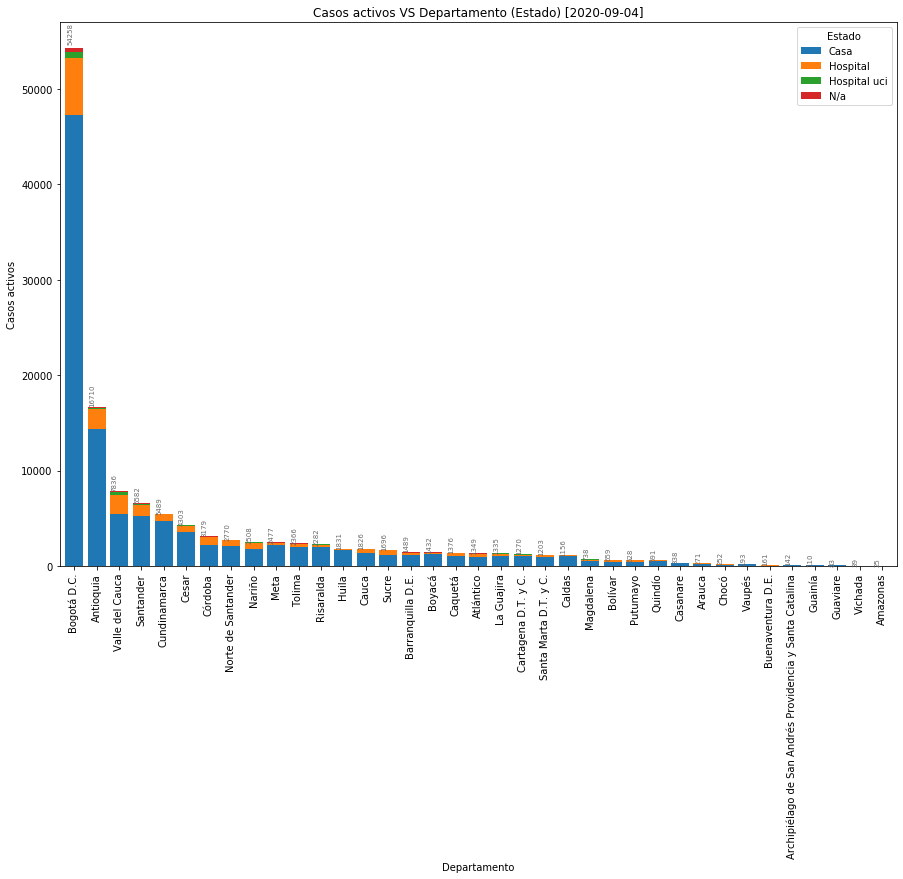

In [13]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [14]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         47261.0    6027.0   
Antioquia                                           14336.0    2082.0   
Valle del Cauca                                      5495.0    1989.0   
Santander                                            5276.0    1173.0   
Cundinamarca                                         4743.0     670.0   
Cesar                                                3533.0     703.0   
Córdoba                                              2189.0     837.0   
Norte de Santander                                   2053.0     630.0   
Nariño                                               1818.0     608.0   
Meta                                                 2246.0     203.0   
Tolima                                               2003.0     299.0   
Risaralda                                            2022.0     227.0   
Huila                                                1700.0      74.0   
Cauca                                                1346.0     416.0   
Sucre                                                1154.0     495.0   
Barranquilla D.E.                                    1149.0     215.0   
Boyacá                                               1228.0     176.0   
Caquetá                                              1062.0     291.0   
Atlántico                                             934.0     280.0   
La Guajira                                           1085.0     219.0   
Cartagena D.T. y C.                                  1011.0     189.0   
Santa Marta D.T. y C.                                 920.0     252.0   
Caldas                                               1049.0      89.0   
Magdalena                                             494.0     191.0   
Bolívar                                               476.0     137.0   
Putumayo                                              396.0     224.0   
Quindío                                               538.0      52.0   
Casanare                                              271.0      59.0   
Arauca                                                246.0      22.0   
Chocó                                                  90.0     135.0   
Vaupés                                                183.0      10.0   
Buenaventura D.E.                                      48.0      90.0   
Archipiélago de San Andrés Providencia y Santa ...    130.0      11.0   
Guainía                                               109.0       1.0   
Guaviare                                               75.0       6.0   
Vichada                                                38.0       1.0   
Amazonas                                               17.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                617.0  353.0   
Antioquia                                                  172.0  120.0   
Valle del Cauca                                            230.0  122.0   
Santander                                                  100.0   33.0   
Cundinamarca                                                44.0   32.0   
Cesar                                                       46.0   21.0   
Córdoba                                                     55.0   98.0   
Norte de Santander                                          66.0   21.0   
Nariño                                                      49.0   33.0   
Meta                                                        11.0   17.0   
Tolima                                                      33.0   31.0   
Risaralda                                                   22.0   11.0   
Huila                                                       42.0   15.0   
Cauca                      

### - Recuperados y Fallecidos VS Departamento

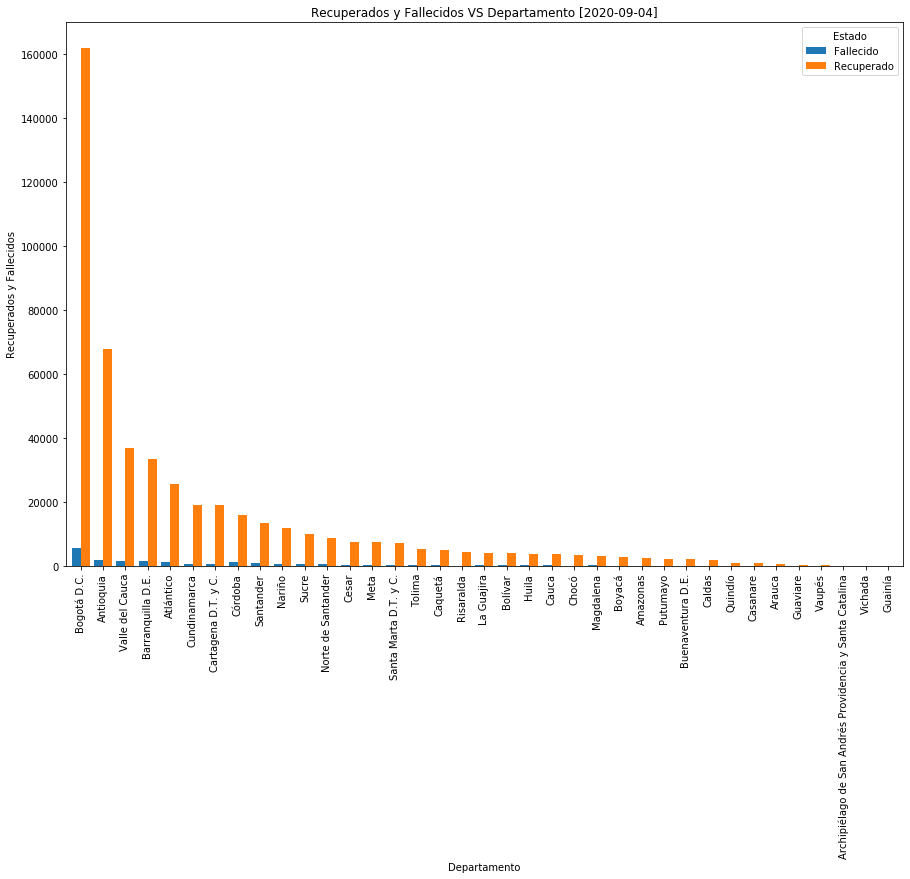

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=(f'Recuperados y Fallecidos VS Departamento [{date}]'))
ax.set_ylabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [16]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            5712.0    161768.0
Antioquia                                              1831.0     67885.0
Valle del Cauca                                        1690.0     37041.0
Barranquilla D.E.                                      1625.0     33406.0
Atlántico                                              1305.0     25673.0
Cundinamarca                                            729.0     18926.0
Cartagena D.T. y C.                                     528.0     18960.0
Córdoba                                                1375.0     16014.0
Santander                                               865.0     13375.0
Nariño                                                  554.0     11755.0
Sucre                                                   521.0      9964.0
Norte de Santander                                      692.0      8918.0
Cesar                                                   345.0      7580.0
Meta                                                    250.0      7481.0
Santa Marta D.T. y C.                                   366.0      7246.0
Tolima                                                  204.0      5399.0
Caquetá                                                 215.0      4930.0
Risaralda                                               128.0      4545.0
La Guajira                                              247.0      4091.0
Bolívar                                                 195.0      4111.0
Huila                                                   172.0      3915.0
Cauca                                                   176.0      3898.0
Chocó                                                   141.0      3381.0
Magdalena                                               344.0      3055.0
Boyacá                                                   87.0      2750.0
Amazonas                                                111.0      2572.0
Putumayo                                                141.0      2316.0
Buenaventura D.E.                                       161.0      2101.0
Caldas                                                   70.0      2016.0
Quindío                                                  45.0       874.0
Casanare                                                 26.0       813.0
Arauca                                                   19.0       766.0
Guaviare                                                  4.0       241.0
Vaupés                                                    1.0       192.0
Archipiélago de San Andrés Providencia y Santa ...        4.0       135.0
Vichada                                                   3.0        79.0
Guainía                                                   6.0        49.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados VS Departamento (Estado)

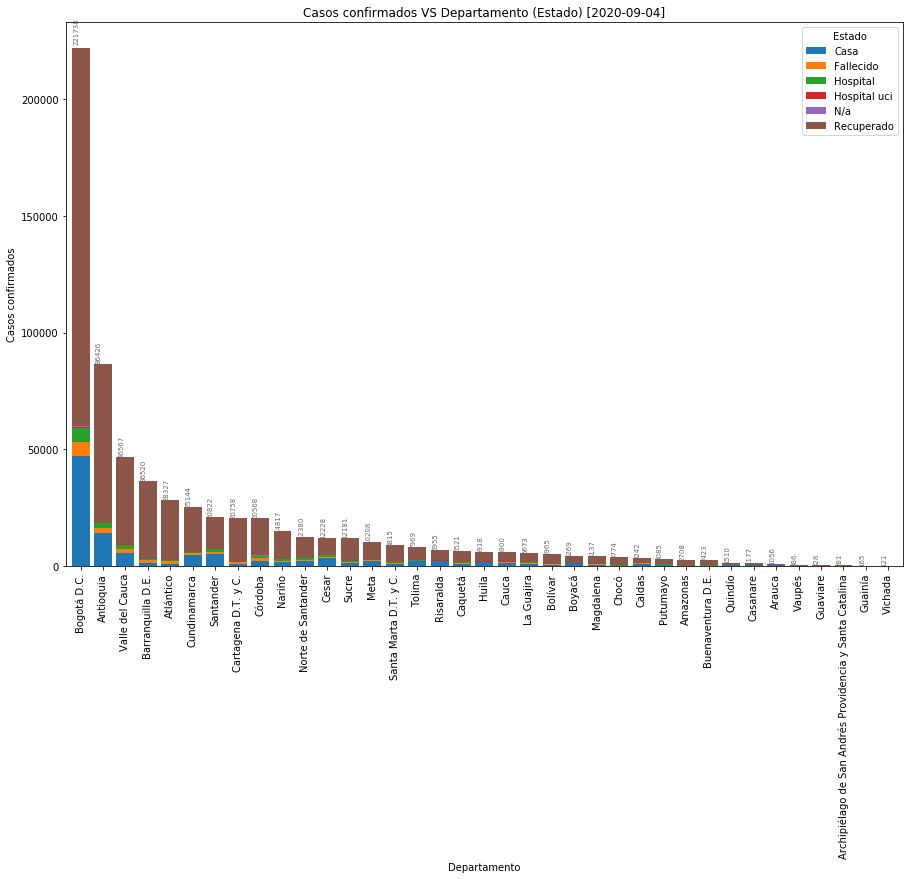

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         47261.0     5712.0   
Antioquia                                           14336.0     1831.0   
Valle del Cauca                                      5495.0     1690.0   
Barranquilla D.E.                                    1149.0     1625.0   
Atlántico                                             934.0     1305.0   
Cundinamarca                                         4743.0      729.0   
Santander                                            5276.0      865.0   
Cartagena D.T. y C.                                  1011.0      528.0   
Córdoba                                              2189.0     1375.0   
Nariño                                               1818.0      554.0   
Norte de Santander                                   2053.0      692.0   
Cesar                                                3533.0      345.0   
Sucre                                                1154.0      521.0   
Meta                                                 2246.0      250.0   
Santa Marta D.T. y C.                                 920.0      366.0   
Tolima                                               2003.0      204.0   
Risaralda                                            2022.0      128.0   
Caquetá                                              1062.0      215.0   
Huila                                                1700.0      172.0   
Cauca                                                1346.0      176.0   
La Guajira                                           1085.0      247.0   
Bolívar                                               476.0      195.0   
Boyacá                                               1228.0       87.0   
Magdalena                                             494.0      344.0   
Chocó                                                  90.0      141.0   
Caldas                                               1049.0       70.0   
Putumayo                                              396.0      141.0   
Amazonas                                               17.0      111.0   
Buenaventura D.E.                                      48.0      161.0   
Quindío                                               538.0       45.0   
Casanare                                              271.0       26.0   
Arauca                                                246.0       19.0   
Vaupés                                                183.0        1.0   
Guaviare                                               75.0        4.0   
Archipiélago de San Andrés Providencia y Santa ...    130.0        4.0   
Guainía                                               109.0        6.0   
Vichada                                                38.0        3.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           6027.0         617.0   
Antioquia                                             2082.0         172.0   
Valle del Cauca                                       1989.0         230.0   
Barranquilla D.E.                                      215.0          21.0   
Atlántico                                              280.0          43.0   
Cundinamarca                                           670.0          44.0   
Santander                                             1173.0         100.0   
Cartagena D.T. y C.                                    189.0          36.0   
Córdoba                                                837.0          55.0   
Nariño                                                 608.0          49.0   
Norte de Santander                                     630.0          66.0   
Cesar                                                  703.0          46.0   
Sucre                

### - Casos confirmados VS Departamento (Sexo)

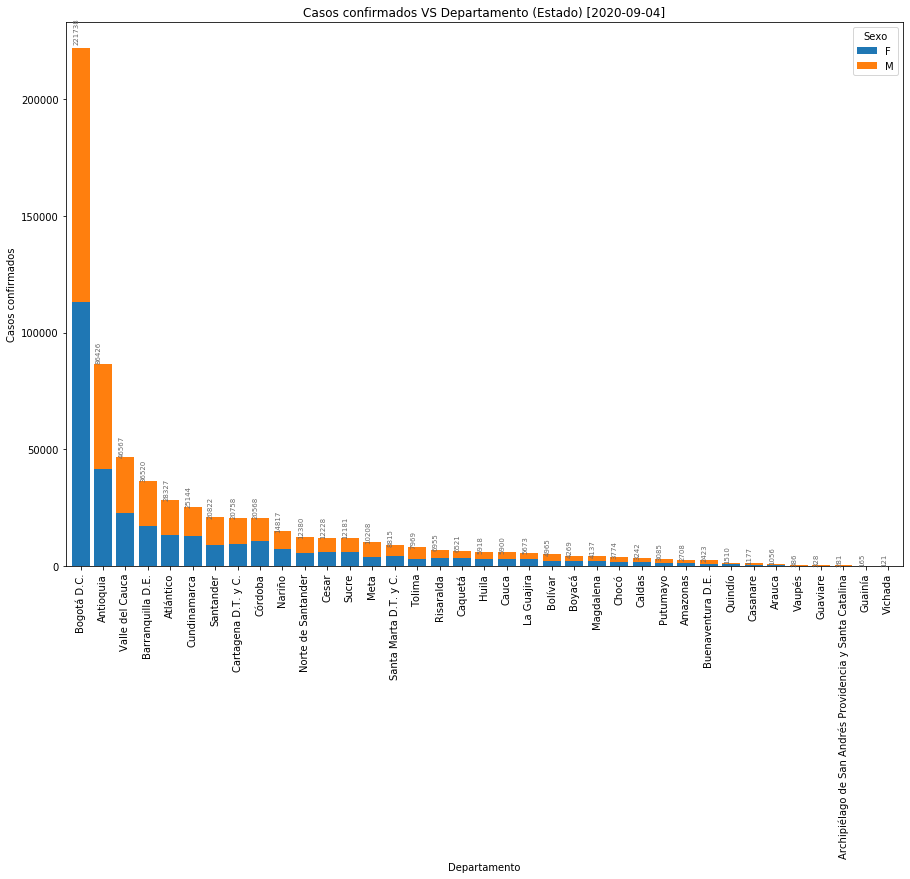

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1].iloc[::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         112918  108820  221738
Antioquia                                            41551   44875   86426
Valle del Cauca                                      22620   23947   46567
Barranquilla D.E.                                    17251   19269   36520
Atlántico                                            13410   14917   28327
Cundinamarca                                         12757   12387   25144
Santander                                             9203   11619   20822
Cartagena D.T. y C.                                   9600   11158   20758
Córdoba                                              10575    9993   20568
Nariño                                                7149    7668   14817
Norte de Santander                                    5756    6624   12380
Cesar                                                 5820    6408   12228
Sucre                                                 5957    6224   12181
Meta                                                  3945    6263   10208
Santa Marta D.T. y C.                                 4414    4401    8815
Tolima                                                3098    4871    7969
Risaralda                                             3318    3637    6955
Caquetá                                               3235    3286    6521
Huila                                                 2936    2982    5918
Cauca                                                 2829    3071    5900
La Guajira                                            2885    2788    5673
Bolívar                                               2322    2643    4965
Boyacá                                                1997    2272    4269
Magdalena                                             2099    2038    4137
Chocó                                                 1790    1984    3774
Caldas                                                1534    1708    3242
Putumayo                                              1427    1658    3085
Amazonas                                              1166    1542    2708
Buenaventura D.E.                                      906    1517    2423
Quindío                                                744     766    1510
Casanare                                               491     686    1177
Arauca                                                 364     692    1056
Vaupés                                                 167     219     386
Guaviare                                                71     257     328
Archipiélago de San Andrés Providencia y Santa ...     153     128     281
Guainía                                                 67      98     165
Vichada                                                 33      88     121

### - Mapa de influencia COVID-19 (Colombia)

In [21]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

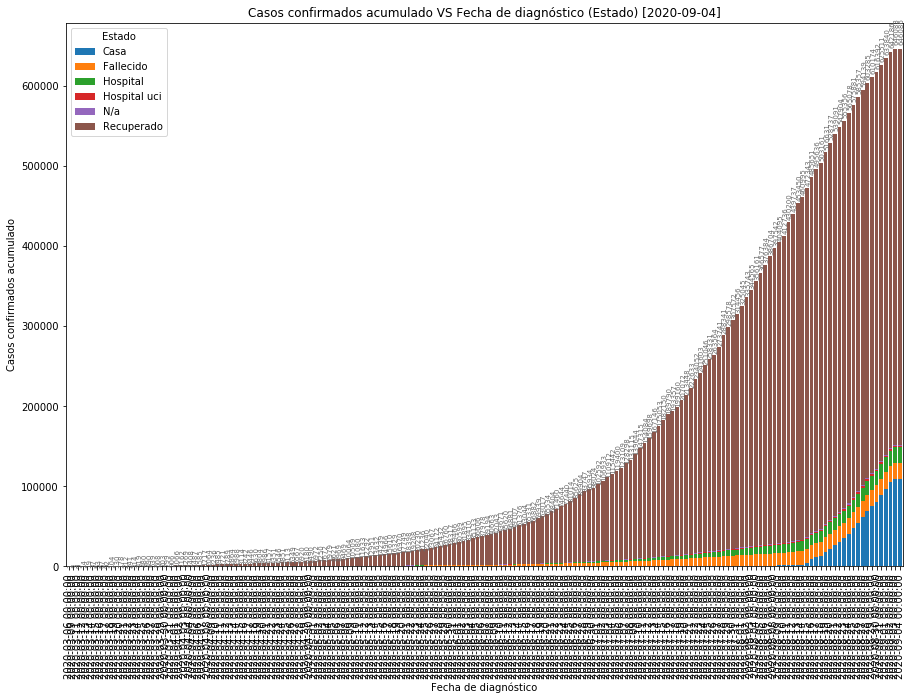

In [22]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [23]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                    Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                        
2020-09-04            108592.0    20682.0   19038.0        1784.0  1321.0   
2020-09-03            108591.0    20682.0   19036.0        1784.0  1321.0   
2020-09-02            104893.0    20680.0   18839.0        1784.0  1321.0   
2020-09-01             96851.0    20613.0   18615.0        1782.0  1320.0   
2020-08-31             88992.0    20537.0   18350.0        1779.0  1319.0   
2020-08-30             80535.0    20453.0   17952.0        1776.0  1313.0   
2020-08-29             74807.0    20389.0   17669.0        1766.0  1309.0   
2020-08-28             68939.0    20286.0   17381.0        1740.0  1304.0   
2020-08-27             61035.0    20159.0   16890.0        1710.0  1302.0   
2020-08-26             53990.0    20017.0   16457.0        1681.0  1292.0   
2020-08-25             47512.0    19815.0   16030.0        1632.0  1282.0   
2020-08-24             40238.0    19638.0   15644.0        1601.0  1270.0   
2020-08-23             34814.0    19426.0   15253.0        1563.0  1255.0   
2020-08-22             30632.0    19296.0   14960.0        1542.0  1252.0   
2020-08-21             26088.0    19080.0   14552.0        1529.0  1244.0   
2020-08-20             21913.0    18837.0   14111.0        1495.0  1226.0   
2020-08-19             17962.0    18461.0   13534.0        1438.0  1211.0   
2020-08-18             12233.0    18161.0   13062.0        1384.0  1194.0   
2020-08-17             11007.0    17918.0   12768.0        1375.0  1173.0   
2020-08-16              8868.0    17736.0   12500.0        1350.0  1164.0   
2020-08-15              4581.0    17439.0   12132.0        1322.0  1155.0   
2020-08-14              2072.0    17143.0   11762.0        1302.0  1146.0   
2020-08-13              1820.0    16901.0   11526.0        1291.0  1136.0   
2020-08-12              1627.0    16588.0   11136.0        1266.0  1119.0   
2020-08-11              1401.0    16228.0   10788.0        1239.0  1106.0   
2020-08-10              1206.0    15815.0   10262.0        1197.0  1085.0   
2020-08-09              1104.0    15584.0    9986.0        1176.0  1067.0   
2020-08-08               947.0    15361.0    9754.0        1163.0  1060.0   
2020-08-07               918.0    15041.0    9508.0        1141.0  1044.0   
2020-08-06               875.0    14751.0    9244.0        1100.0  1024.0   
2020-08-05               851.0    14463.0    9012.0        1064.0  1003.0   
2020-08-04               815.0    14166.0    8726.0        1034.0   980.0   
2020-08-03               788.0    13838.0    8447.0        1002.0   964.0   
2020-08-02               749.0    13493.0    8126.0         983.0   943.0   
2020-08-01               729.0    13126.0    7771.0         952.0   929.0   
2020-07-31               703.0    12777.0    7361.0         921.0   908.0   
2020-07-30               688.0    12534.0    7141.0         906.0   892.0   
2020-07-29               667.0    12238.0    6898.0         871.0   871.0   
2020-07-28               629.0    11938.0    6631.0         835.0   848.0   
2020-07-27               595.0    11378.0    6188.0         789.0   806.0   
2020-07-26               575.0    11048.0    5930.0         759.0   781.0   
2020-07-25               561.0    10801.0    5762.0         741.0   767.0   
2020-07-24               544.0    10495.0    5493.0         710.0   749.0   
2020-07-23               531.0    10190.0    5234.0         685.0   728.0   
2020-07-22               508.0     9812.0    4928.0         650.0   699.0   
2020-07-21               479.0     9364.0    4546.0         609.0   672.0   
2020-07-20               457.0     9013.0    4312.0         574.0   657.0   
2020-07-19               442.0     8739.0    4050.0         548.0   645.0   
2020-07-18               422.0     8456.0    3861.0         529.0   628.0   
2020-07-17               402.0     8213.0    3714.0         507.0   606.0

### - Casos confirmados VS Fecha de diagnóstico (Estado)

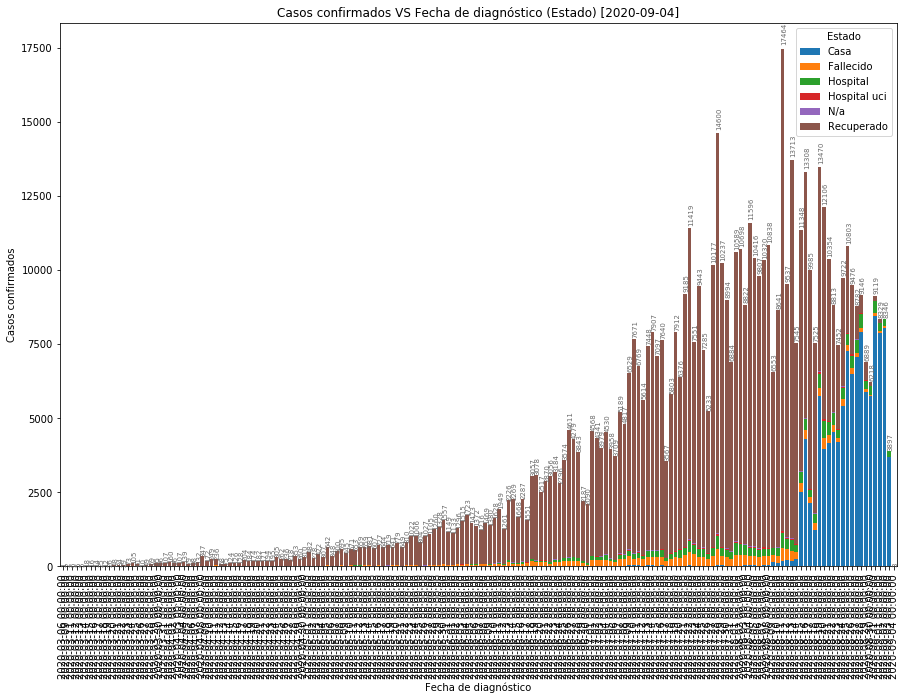

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-09-04               1.0        0.0       2.0           0.0   0.0   
2020-09-03            3698.0        2.0     197.0           0.0   0.0   
2020-09-02            8042.0       67.0     224.0           2.0   1.0   
2020-09-01            7859.0       76.0     265.0           3.0   1.0   
2020-08-31            8457.0       84.0     398.0           3.0   6.0   
2020-08-30            5728.0       64.0     283.0          10.0   4.0   
2020-08-29            5868.0      103.0     288.0          26.0   5.0   
2020-08-28            7904.0      127.0     491.0          30.0   2.0   
2020-08-27            7045.0      142.0     433.0          29.0  10.0   
2020-08-26            6478.0      202.0     427.0          49.0  10.0   
2020-08-25            7274.0      177.0     386.0          31.0  12.0   
2020-08-24            5424.0      212.0     391.0          38.0  15.0   
2020-08-23            4182.0      130.0     293.0          21.0   3.0   
2020-08-22            4544.0      216.0     408.0          13.0   8.0   
2020-08-21            4175.0      243.0     441.0          34.0  18.0   
2020-08-20            3951.0      376.0     577.0          57.0  15.0   
2020-08-19            5729.0      300.0     472.0          54.0  17.0   
2020-08-18            1226.0      243.0     294.0           9.0  21.0   
2020-08-17            2139.0      182.0     268.0          25.0   9.0   
2020-08-16            4287.0      297.0     368.0          28.0   9.0   
2020-08-15            2509.0      296.0     370.0          20.0   9.0   
2020-08-14             252.0      242.0     236.0          11.0  10.0   
2020-08-13             193.0      313.0     390.0          25.0  17.0   
2020-08-12             226.0      360.0     348.0          27.0  13.0   
2020-08-11             195.0      413.0     526.0          42.0  21.0   
2020-08-10             102.0      231.0     276.0          21.0  18.0   
2020-08-09             157.0      223.0     232.0          13.0   7.0   
2020-08-08              29.0      320.0     246.0          22.0  16.0   
2020-08-07              43.0      290.0     264.0          41.0  20.0   
2020-08-06              24.0      288.0     232.0          36.0  21.0   
2020-08-05              36.0      297.0     286.0          30.0  23.0   
2020-08-04              27.0      328.0     279.0          32.0  16.0   
2020-08-03              39.0      345.0     321.0          19.0  21.0   
2020-08-02              20.0      367.0     355.0          31.0  14.0   
2020-08-01              26.0      349.0     410.0          31.0  21.0   
2020-07-31              15.0      243.0     220.0          15.0  16.0   
2020-07-30              21.0      296.0     243.0          35.0  21.0   
2020-07-29              38.0      300.0     267.0          36.0  23.0   
2020-07-28              34.0      560.0     443.0          46.0  42.0   
2020-07-27              20.0      330.0     258.0          30.0  25.0   
2020-07-26              14.0      247.0     168.0          18.0  14.0   
2020-07-25              17.0      306.0     269.0          31.0  18.0   
2020-07-24              13.0      305.0     259.0          25.0  21.0   
2020-07-23              23.0      378.0     306.0          35.0  29.0   
2020-07-22              29.0      448.0     382.0          41.0  27.0   
2020-07-21              22.0      351.0     234.0          35.0  15.0   
2020-07-20              15.0      274.0     262.0          26.0  12.0   
2020-07-19              20.0      283.0     189.0          19.0  17.0   
2020-07-18              20.0      243.0     147.0          22.0  22.0   
2020-07-17              11.0      177.0      86.0          11.0   9.0   
2020-07-16              38.0      287.0     220.0          28.0  20.0   
2020-07-15              23.0      296.0     184.0          23.0  11.0   
2020-07-14              37.0      287.0     178.0         

### - Casos confirmados VS Clasificación de edad (Estado)

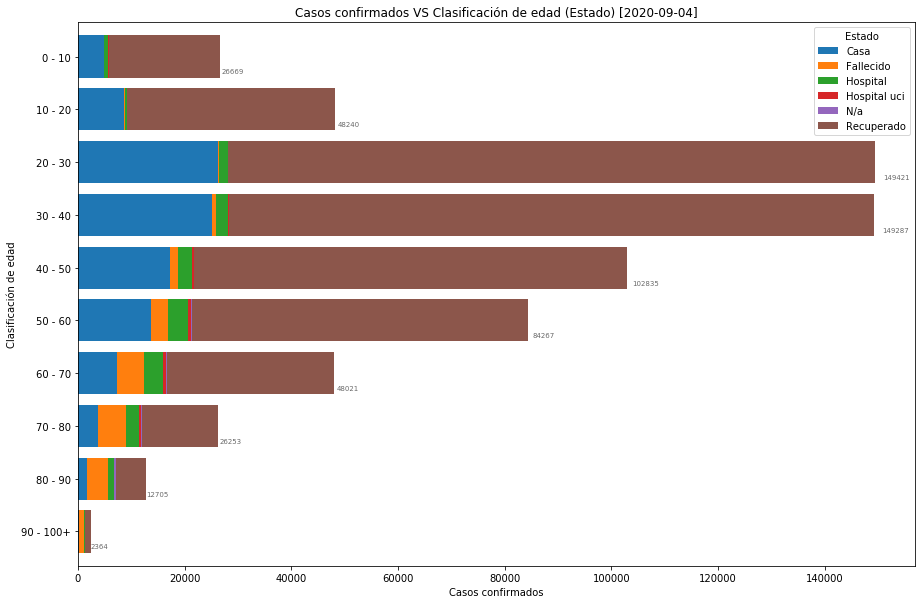

In [26]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Estado) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [27]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  4812         35       859            38   32   
10 - 20                 8718         34       423            22   25   
20 - 30                26174        266      1612            67   58   
30 - 40                25134        679      2324           169   50   
40 - 50                17188       1519      2726           270  100   
50 - 60                13740       3127      3841           419  160   
60 - 70                 7376       5021      3570           451  280   
70 - 80                 3675       5362      2414           275  318   
80 - 90                 1620       3953      1151            80  259   
90 - 100+                287        892       168             5   63   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      20893  
10 - 20                     39018  
20 - 30                    121244  
30 - 40                    120931  
40 - 50                     81032  
50 - 60                     62980  
60 - 70                     31323  
70 - 80                     14209  
80 - 90                      5642  
90 - 100+                     949

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

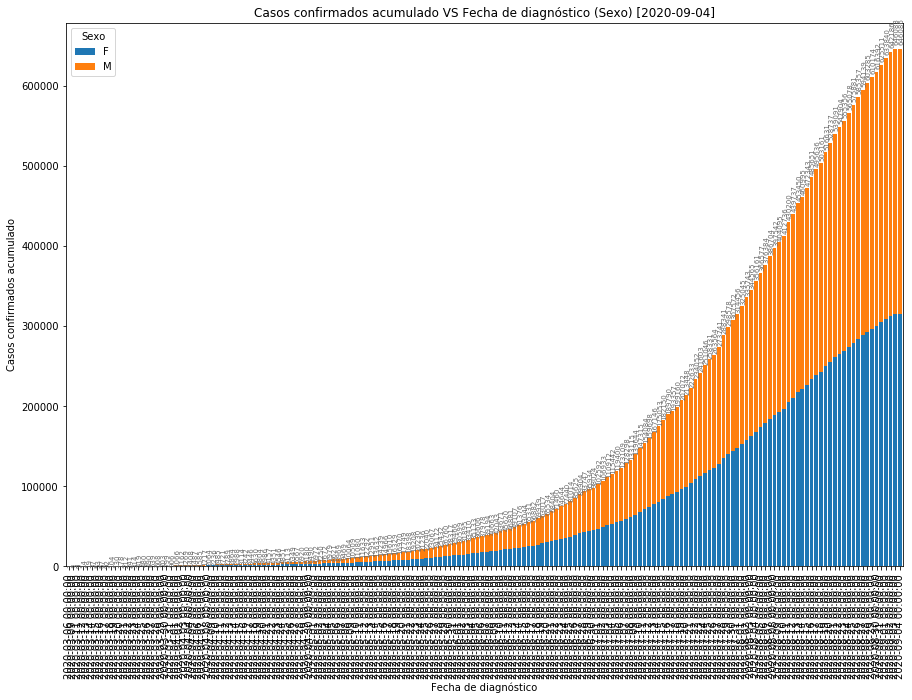

In [28]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [29]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-09-04            314666.0  331420.0
2020-09-03            314664.0  331419.0
2020-09-02            312707.0  329479.0
2020-09-01            308452.0  325388.0
2020-08-31            304282.0  321229.0
2020-08-30            299472.0  316920.0
2020-08-29            296315.0  313859.0
2020-08-28            292823.0  310462.0
2020-08-27            288214.0  305925.0
2020-08-26            283800.0  301557.0
2020-08-25            278966.0  296915.0
2020-08-24            273542.0  291536.0
2020-08-23            268679.0  286677.0
2020-08-22            264906.0  282998.0
2020-08-21            260750.0  278341.0
2020-08-20            255531.0  273206.0
2020-08-19            249432.0  267199.0
2020-08-18            242437.0  260724.0
2020-08-17            238807.0  256829.0
2020-08-16            233531.0  252120.0
2020-08-15            226576.0  245767.0
2020-08-14            220809.0  240186.0
2020-08-13            216945.0  236505.0
2020-08-12            210081.0  229656.0
2020-08-11            205353.0  224847.0
2020-08-10            196302.0  216434.0
2020-08-09            191964.0  212131.0
2020-08-08            188587.0  208955.0
2020-08-07            183313.0  203391.0
2020-08-06            178274.0  198110.0
2020-08-05            173416.0  193161.0
2020-08-04            168206.0  187955.0
2020-08-03            162392.0  182173.0
2020-08-02            158128.0  177615.0
2020-08-01            152660.0  172385.0
2020-07-31            147535.0  166921.0
2020-07-30            144084.0  163488.0
2020-07-29            139707.0  158871.0
2020-07-28            134634.0  153707.0
2020-07-27            127528.0  146213.0
2020-07-26            122658.0  140906.0
2020-07-25            120261.0  138070.0
2020-07-24            116584.0  134462.0
2020-07-23            112217.0  129386.0
2020-07-22            108652.0  125400.0
2020-07-21            103491.0  119142.0
2020-07-20             99196.0  114252.0
2020-07-19             96220.0  110852.0
2020-07-18             92435.0  106725.0
2020-07-17             89659.0  103698.0
2020-07-16             87900.0  101890.0
2020-07-15             84157.0   97993.0
2020-07-14             80797.0   94256.0
2020-07-13             77198.0   89948.0
2020-07-12             73631.0   86067.0
2020-07-11             70960.0   83124.0
2020-07-10             67742.0   79573.0
2020-07-09             64241.0   75403.0
2020-07-08             61279.0   71836.0
2020-07-07             58968.0   69330.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

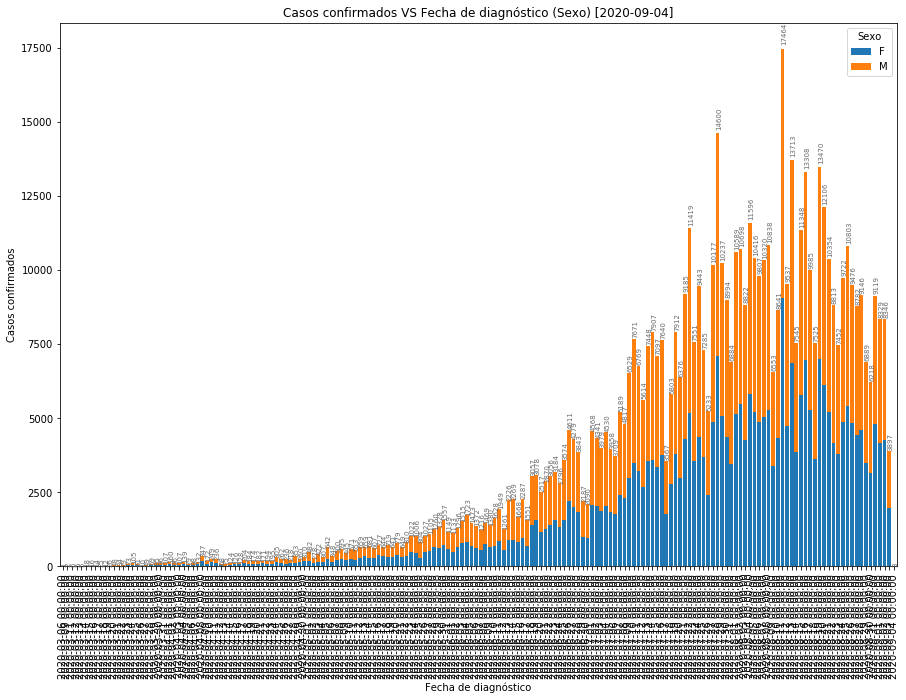

In [30]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [31]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-09-04               2.0     1.0
2020-09-03            1957.0  1940.0
2020-09-02            4255.0  4091.0
2020-09-01            4170.0  4159.0
2020-08-31            4810.0  4309.0
2020-08-30            3157.0  3061.0
2020-08-29            3492.0  3397.0
2020-08-28            4609.0  4537.0
2020-08-27            4414.0  4368.0
2020-08-26            4834.0  4642.0
2020-08-25            5424.0  5379.0
2020-08-24            4863.0  4859.0
2020-08-23            3773.0  3679.0
2020-08-22            4156.0  4657.0
2020-08-21            5219.0  5135.0
2020-08-20            6099.0  6007.0
2020-08-19            6995.0  6475.0
2020-08-18            3630.0  3895.0
2020-08-17            5276.0  4709.0
2020-08-16            6955.0  6353.0
2020-08-15            5767.0  5581.0
2020-08-14            3864.0  3681.0
2020-08-13            6864.0  6849.0
2020-08-12            4728.0  4809.0
2020-08-11            9051.0  8413.0
2020-08-10            4338.0  4303.0
2020-08-09            3377.0  3176.0
2020-08-08            5274.0  5564.0
2020-08-07            5039.0  5281.0
2020-08-06            4858.0  4949.0
2020-08-05            5210.0  5206.0
2020-08-04            5814.0  5782.0
2020-08-03            4264.0  4558.0
2020-08-02            5468.0  5230.0
2020-08-01            5125.0  5464.0
2020-07-31            3451.0  3433.0
2020-07-30            4377.0  4617.0
2020-07-29            5073.0  5164.0
2020-07-28            7106.0  7494.0
2020-07-27            4870.0  5307.0
2020-07-26            2397.0  2836.0
2020-07-25            3677.0  3608.0
2020-07-24            4367.0  5076.0
2020-07-23            3565.0  3986.0
2020-07-22            5161.0  6258.0
2020-07-21            4295.0  4890.0
2020-07-20            2976.0  3400.0
2020-07-19            3785.0  4127.0
2020-07-18            2776.0  3027.0
2020-07-17            1759.0  1808.0
2020-07-16            3743.0  3897.0
2020-07-15            3360.0  3737.0
2020-07-14            3599.0  4308.0
2020-07-13            3567.0  3881.0
2020-07-12            2671.0  2943.0
2020-07-11            3218.0  3551.0
2020-07-10            3501.0  4170.0
2020-07-09            2962.0  3567.0
2020-07-08            2311.0  2506.0
2020-07-07            2406.0  2783.0

### - Casos confirmados VS Clasificación de edad (Sexo)

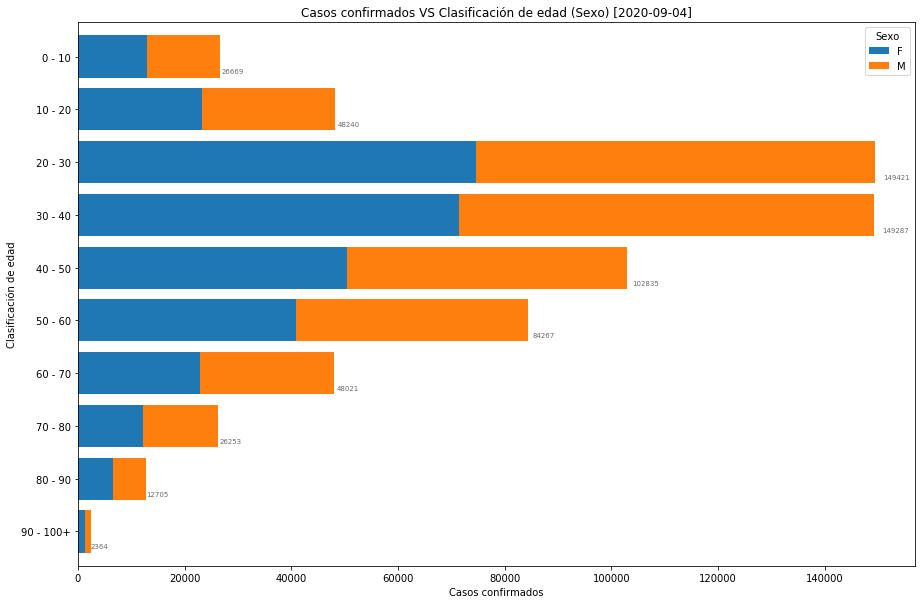

In [32]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [33]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 12999  13670
10 - 20                23258  24982
20 - 30                74630  74791
30 - 40                71349  77938
40 - 50                50428  52407
50 - 60                40899  43368
60 - 70                22908  25113
70 - 80                12248  14005
80 - 90                 6503   6202
90 - 100+               1336   1028

### - Casos confirmados VS Estado (Sexo)

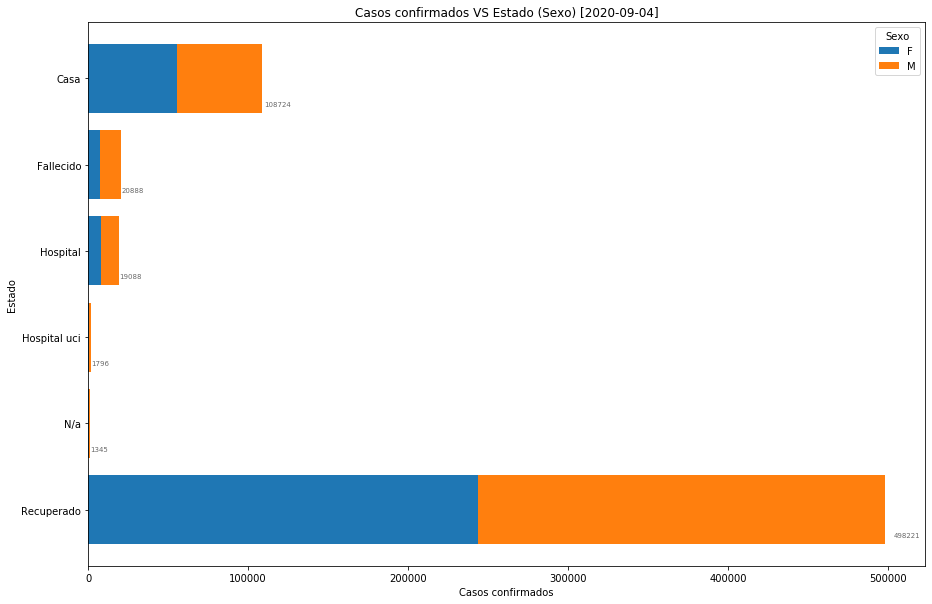

In [34]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [35]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           55737   52987
Fallecido       7476   13412
Hospital        8147   10941
Hospital uci     628    1168
N/a              580     765
Recuperado    243990  254231

### - Casos confirmados VS Tipo de contagio (Sexo)

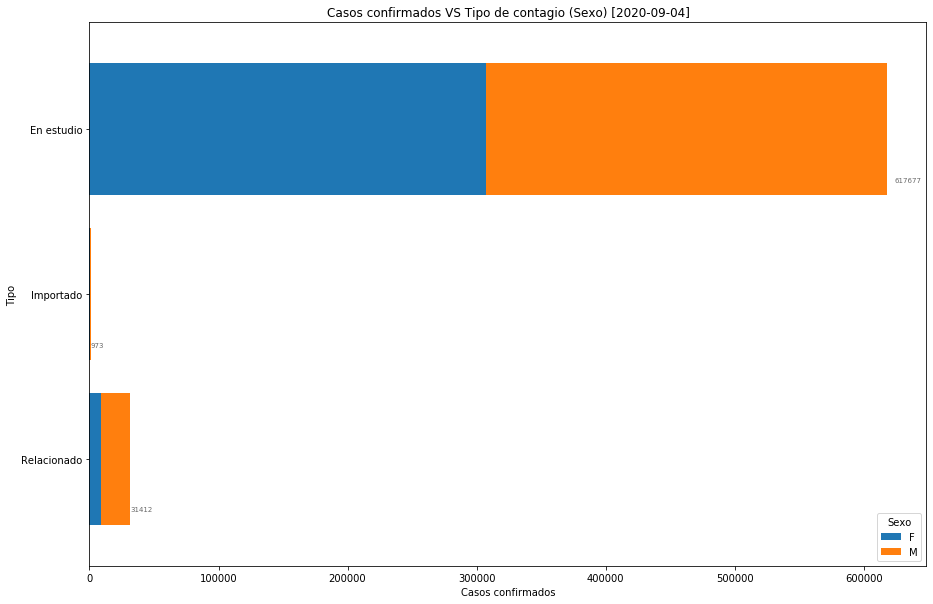

In [36]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo de contagio (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [37]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   307278  310399
Importado       460     513
Relacionado    8820   22592

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

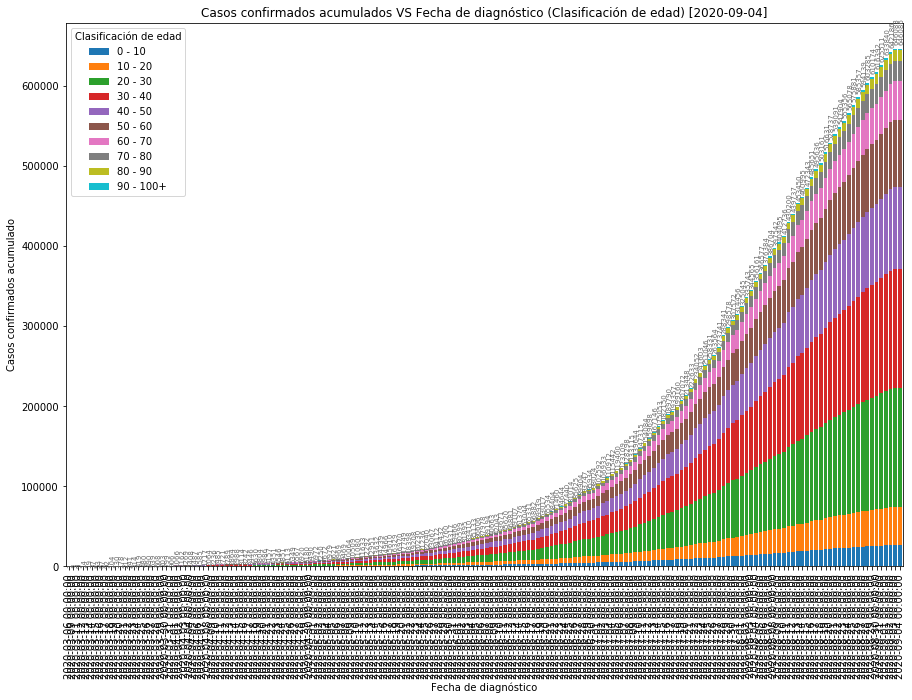

In [38]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [39]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-04              26530    47954   148457   148331   102247    83783   
2020-09-03              26530    47954   148457   148330   102247    83783   
2020-09-02              26387    47646   147566   147477   101626    83263   
2020-09-01              26028    47075   145704   145636   100324    82155   
2020-08-31              25691    46428   143793   143752    99041    81047   
2020-08-30              25277    45731   141609   141727    97606    79921   
2020-08-29              25033    45262   140138   140328    96629    79124   
2020-08-28              24782    44738   138527   138814    95562    78180   
2020-08-27              24460    44117   136480   136666    94126    76952   
2020-08-26              24114    43483   134434   134650    92729    75828   
2020-08-25              23764    42772   132393   132495    91195    74645   
2020-08-24              23373    42075   129942   129951    89448    73202   
2020-08-23              23009    41360   127679   127769    87926    71941   
2020-08-22              22699    40755   125903   126034    86823    70958   
2020-08-21              22376    40095   123870   123937    85499    69844   
2020-08-20              21954    39347   121405   121578    83863    68491   
2020-08-19              21469    38489   118746   118861    81937    66875   
2020-08-18              20840    37505   115716   115841    79723    65174   
2020-08-17              20585    36991   114038   114145    78523    64145   
2020-08-16              20071    36230   111826   112045    76930    62807   
2020-08-15              19453    35093   108865   109146    74811    61057   
2020-08-14              18953    34254   106251   106638    73024    59530   
2020-08-13              18700    33708   104522   104961    71807    58468   
2020-08-12              18077    32644   101417   101857    69616    56663   
2020-08-11              17729    32007    99330    99649    68100    55398   
2020-08-10              16932    30751    95208    95609    65262    53148   
2020-08-09              16601    30070    93257    93602    63908    52033   
2020-08-08              16357    29643    91749    92173    62826    51149   
2020-08-07              15940    28859    89308    89528    61120    49728   
2020-08-06              15526    28088    86948    87093    59480    48392   
2020-08-05              15077    27343    84768    84852    57910    47117   
2020-08-04              14650    26617    82381    82439    56222    45750   
2020-08-03              14161    25799    79723    79728    54319    44167   
2020-08-02              13837    25190    77723    77677    52972    42949   
2020-08-01              13394    24470    75312    75282    51165    41448   
2020-07-31              12980    23614    72757    72771    49544    40101   
2020-07-30              12707    23156    71226    71134    48369    39251   
2020-07-29              12363    22443    69044    69002    47042    38075   
2020-07-28              11981    21697    66617    66527    45356    36830   
2020-07-27              11352    20560    63292    63239    43039    34897   
2020-07-26              10966    19838    60904    60854    41368    33684   
2020-07-25              10756    19513    59715    59627    40554    33003   
2020-07-24              10472    19029    58078    57923    39388    32012   
2020-07-23              10151    18308    55874    55634    37910    30778   
2020-07-22               9874    17792    54190    53886    36709    29788   
2020-07-21               9468    16944    51468    51297    34923    28243   
2020-07-20               9108    16317    49303    49115    33439    27091   
2020-07-19               8830    15857    47948    47654    32369    26262   
2020-07-18               8517    15197    46114    45798    31059    25280   
2020-07-17            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

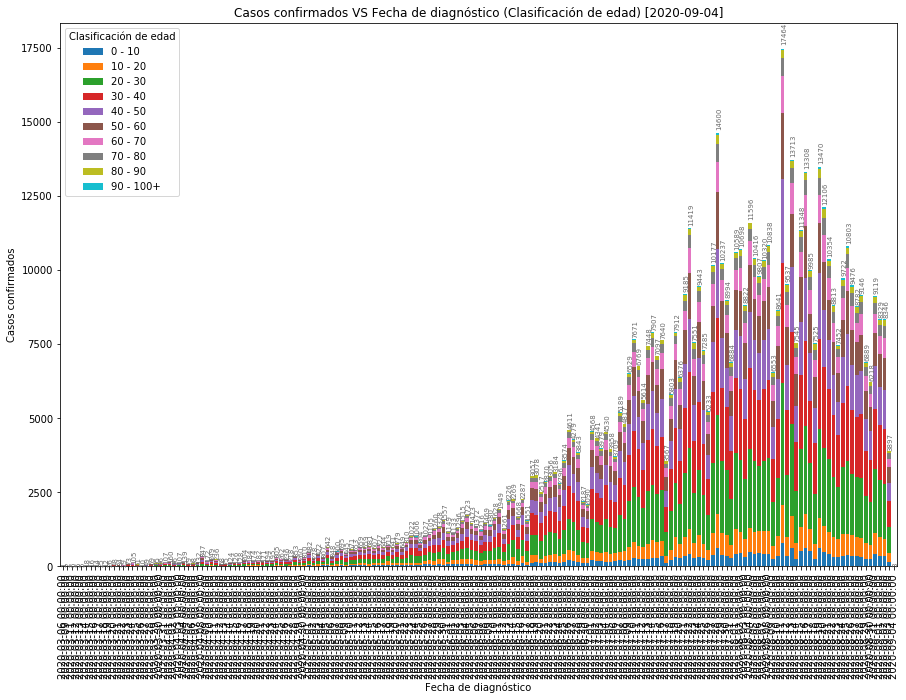

In [40]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [41]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-04                  0        0        0        1        0        0   
2020-09-03                143      308      891      853      621      520   
2020-09-02                359      571     1862     1841     1302     1108   
2020-09-01                337      647     1911     1884     1283     1108   
2020-08-31                414      697     2184     2025     1435     1126   
2020-08-30                244      469     1471     1399      977      797   
2020-08-29                251      524     1611     1514     1067      944   
2020-08-28                322      621     2047     2148     1436     1228   
2020-08-27                346      634     2046     2016     1397     1124   
2020-08-26                350      711     2041     2155     1534     1183   
2020-08-25                391      697     2451     2544     1747     1443   
2020-08-24                364      715     2263     2182     1522     1261   
2020-08-23                310      605     1776     1735     1103      983   
2020-08-22                323      660     2033     2097     1324     1114   
2020-08-21                422      748     2465     2359     1636     1353   
2020-08-20                485      858     2659     2717     1926     1616   
2020-08-19                629      984     3030     3020     2214     1701   
2020-08-18                255      514     1678     1696     1200     1029   
2020-08-17                514      761     2212     2100     1593     1338   
2020-08-16                618     1137     2961     2899     2119     1750   
2020-08-15                500      839     2614     2508     1787     1527   
2020-08-14                253      546     1729     1677     1217     1062   
2020-08-13                623     1064     3105     3104     2191     1805   
2020-08-12                348      637     2087     2208     1516     1265   
2020-08-11                797     1256     4122     4040     2838     2250   
2020-08-10                331      681     1951     2007     1354     1115   
2020-08-09                244      427     1508     1429     1082      884   
2020-08-08                417      784     2441     2645     1706     1421   
2020-08-07                414      771     2360     2435     1640     1336   
2020-08-06                449      745     2180     2241     1570     1275   
2020-08-05                427      726     2387     2413     1688     1367   
2020-08-04                489      818     2658     2711     1903     1583   
2020-08-03                324      609     2000     2051     1347     1218   
2020-08-02                443      720     2411     2395     1807     1501   
2020-08-01                414      856     2555     2511     1621     1347   
2020-07-31                273      458     1531     1637     1175      850   
2020-07-30                344      713     2182     2132     1327     1176   
2020-07-29                382      746     2427     2475     1686     1245   
2020-07-28                629     1137     3325     3288     2317     1933   
2020-07-27                386      722     2388     2385     1671     1213   
2020-07-26                210      325     1189     1227      814      681   
2020-07-25                284      484     1637     1704     1166      991   
2020-07-24                321      721     2204     2289     1478     1234   
2020-07-23                277      516     1684     1748     1201      990   
2020-07-22                406      848     2722     2589     1786     1545   
2020-07-21                360      627     2165     2182     1484     1152   
2020-07-20                278      460     1355     1461     1070      829   
2020-07-19                313      660     1834     1856     1310      982   
2020-07-18                222      342     1294     1416      956      752   
2020-07-17            

### - Casos confirmados VS Estado (Clasificación de edad)

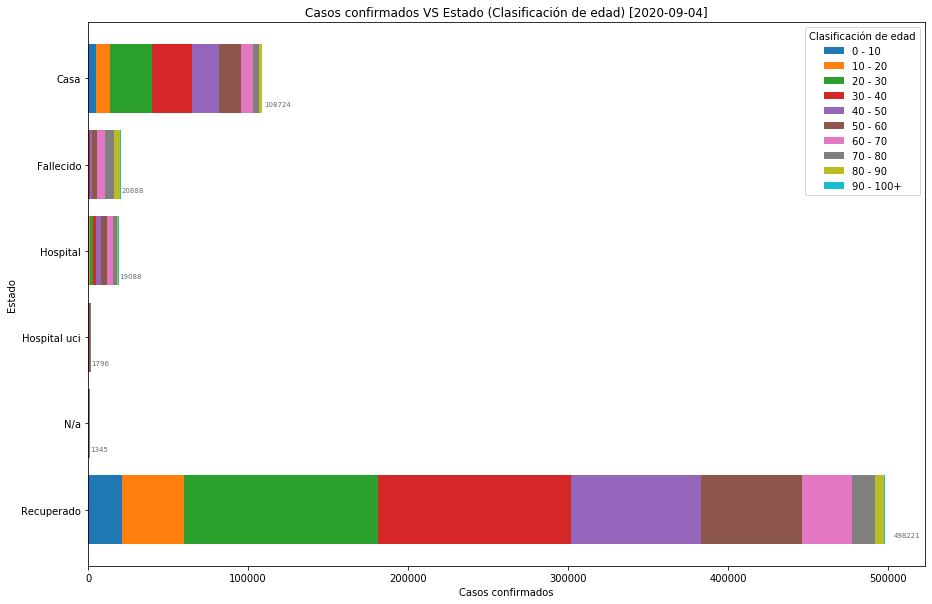

In [42]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [43]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     4812     8718    26174    25134    17188    13740   
Fallecido                  35       34      266      679     1519     3127   
Hospital                  859      423     1612     2324     2726     3841   
Hospital uci               38       22       67      169      270      419   
N/a                        32       25       58       50      100      160   
Recuperado              20893    39018   121244   120931    81032    62980   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      7376     3675     1620        287  
Fallecido                 5021     5362     3953        892  
Hospital                  3570     2414     1151        168  
Hospital uci               451      275       80          5  
N/a                        280      318      259         63  
Recuperado               31323    14209     5642        949

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

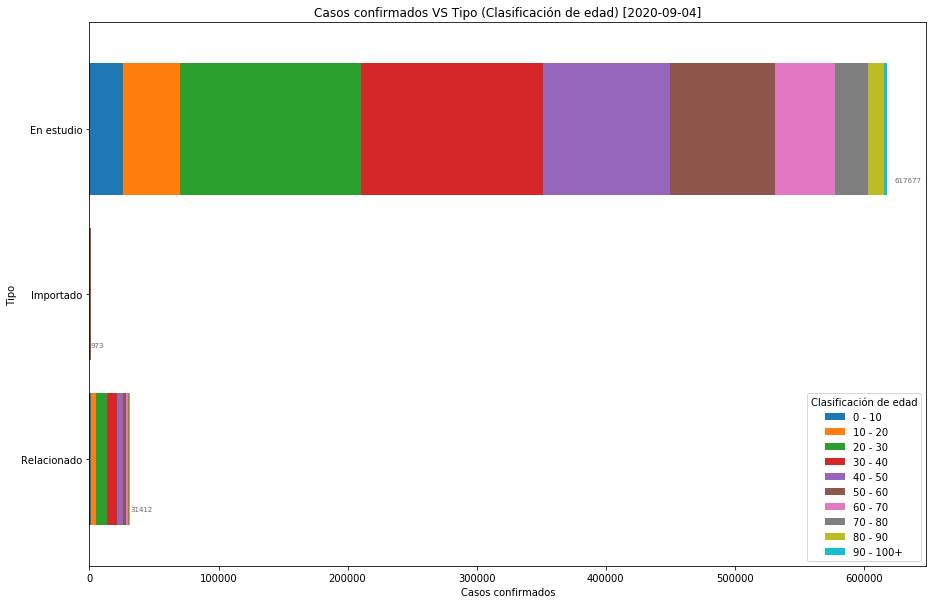

In [44]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [45]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              25643    44355   140410   140967    98673    81387   
Importado                   7       37      241      224      172      146   
Relacionado              1019     3848     8770     8096     3990     2734   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               46466    25463    12110       2203  
Importado                   98       37       10          1  
Relacionado               1457      753      585        160

## Y para los curiosos... 👀

### - Casos activos VS Ciudad de ubicación (Estado) [TOP 50]

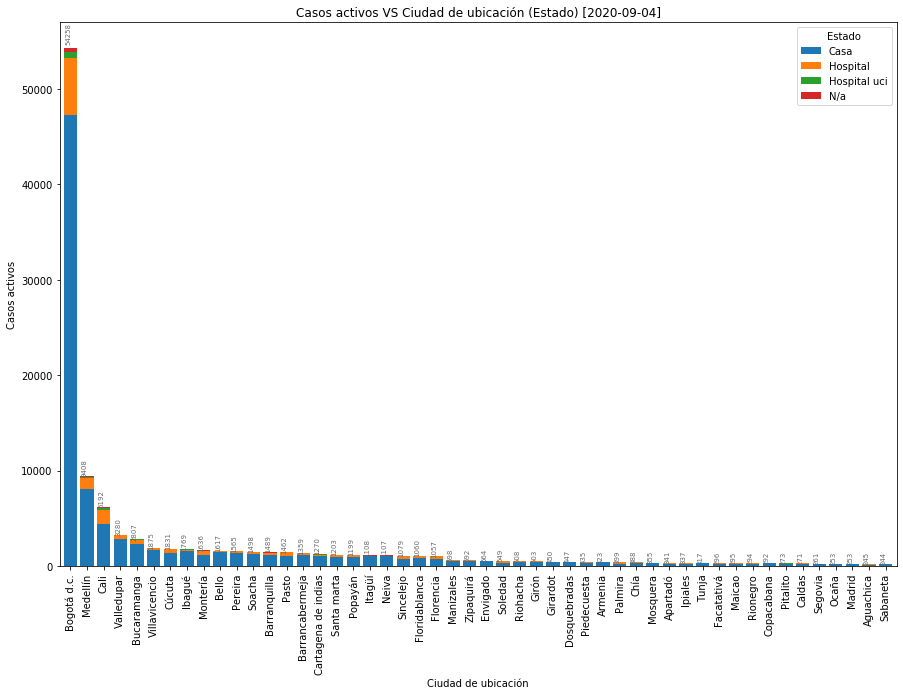

In [46]:
li = data.groupby(['Ciudad de ubicación', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').tail(50).iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Ciudad de ubicación (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [47]:
li.sort_values('Total', ascending=False).head(50)

Estado                  Casa  Hospital  Hospital uci    N/a    Total
Ciudad de ubicación                                                 
Bogotá d.c.          47261.0    6027.0         617.0  353.0  54258.0
Medellín              8110.0    1125.0         111.0   62.0   9408.0
Cali                  4391.0    1517.0         192.0   92.0   6192.0
Valledupar            2811.0     428.0          31.0   10.0   3280.0
Bucaramanga           2277.0     475.0          41.0   14.0   2807.0
Villavicencio         1725.0     129.0           9.0   12.0   1875.0
Cúcuta                1339.0     434.0          46.0   12.0   1831.0
Ibagué                1575.0     157.0          18.0   19.0   1769.0
Montería              1149.0     413.0          28.0   46.0   1636.0
Bello                 1444.0     155.0          13.0    5.0   1617.0
Pereira               1392.0     148.0          17.0    8.0   1565.0
Soacha                1293.0     185.0          13.0    7.0   1498.0
Barranquilla          1149.0     215.0          21.0  104.0   1489.0
Pasto                 1074.0     347.0          26.0   15.0   1462.0
Barrancabermeja       1171.0     173.0          11.0    4.0   1359.0
Cartagena de indias   1011.0     189.0          36.0   34.0   1270.0
Santa marta            920.0     252.0          13.0   18.0   1203.0
Popayán                964.0     209.0          16.0   10.0   1199.0
Itagüí                1016.0      82.0           5.0    5.0   1108.0
Neiva                 1030.0      43.0          27.0    7.0   1107.0
Sincelejo              727.0     324.0          14.0   14.0   1079.0
Floridablanca          815.0     219.0          21.0    5.0   1060.0
Florencia              785.0     257.0           7.0    8.0   1057.0
Manizales              561.0      29.0           2.0    6.0    598.0
Zipaquirá              554.0      33.0           2.0    3.0    592.0
Envigado               515.0      43.0           4.0    2.0    564.0
Soledad                312.0     177.0          18.0   42.0    549.0
Riohacha               403.0      93.0           6.0    6.0    508.0
Girón                  384.0     108.0           8.0    3.0    503.0
Girardot               397.0      50.0           3.0    0.0    450.0
Dosquebradas           389.0      54.0           3.0    1.0    447.0
Piedecuesta            349.0      78.0           8.0    0.0    435.0
Armenia                381.0      41.0           0.0    1.0    423.0
Palmira                253.0     128.0          11.0    7.0    399.0
Chía                   349.0      35.0           1.0    3.0    388.0
Mosquera               312.0      36.0           5.0    2.0    355.0
Apartadó               239.0      94.0           3.0    5.0    341.0
Ipiales                236.0      95.0           3.0    3.0    337.0
Tunja                  269.0      37.0           5.0    6.0    317.0
Facatativá             251.0      39.0           6.0    0.0    296.0
Maicao                 218.0      63.0          13.0    1.0    295.0
Rionegro               243.0      45.0           4.0    2.0    294.0
Copacabana             277.0      13.0           0.0    2.0    292.0
Pitalito               247.0      18.0           5.0    3.0    273.0
Caldas                 255.0      16.0           0.0    0.0    271.0
Segovia                253.0       6.0           2.0    0.0    261.0
Ocaña                  177.0      72.0           3.0    1.0    253.0
Madrid                 222.0      29.0           1.0    1.0    253.0
Aguachica              125.0     111.0           8.0    1.0    245.0
Sabaneta               224.0      19.0           0.0    1.0    244.0

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>

In [48]:
# Data storage
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)